In [3]:
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.3.20
    Uninstalling langgraph-0.3.20:
      Successfully uninstalled langgraph-0.3.20
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
%pip install python-dotenv langchain_groq langchain_ollama


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:

import getpass
import os
from dotenv import find_dotenv, load_dotenv
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
groq_api_key = os.getenv("groq_api_key")
os.environ["groq_api_key"] = groq_api_key 

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("groq_api_key")

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
tavily_api_key = os.getenv("tavily_api_key")
os.environ["tavily_api_key"] = tavily_api_key

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("tavily_api_key")

In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
C:\Users\paulo\AppData\Local\Temp\ipykernel_4812\2391770398.py:23: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\paulo\AppData\Local\Temp\ipykernel_4812\2391770398.py:23: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [3]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder", "expenses_manager"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


#llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

#llm=ChatGroq(groq_api_key=groq_api_key,model_name="Llama-3.3-70b-Versatile")

MODEL_NAME = "llama3.2"
llm = ChatOllama(model=MODEL_NAME, temperature=0.5)
class State(MessagesState):
    next: str

    
call_count = 0
call_count_max = 2
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    global call_count  # Now it refers to the global variable
    global call_count_max

    call_count = call_count +1

    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    if call_count  == call_count_max:
        goto = END

    return Command(goto=goto, update={"next": goto})

In [4]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    print("state:",state)
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    print("state:",state)
    result = code_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


import json
# Load the JSON file
file_path = "monthly_expenses.json"  # Replace with the correct path to your file
with open(file_path, "r") as file:
    data = json.load(file)

# Convert the JSON data to a string
monthly_expenses_json_string = json.dumps(data, indent=4)  # Pretty-printed string

expenses_manager_agent = create_react_agent(llm, tools=[],prompt=f"You are a expenses manager. you data is solely based here{monthly_expenses_json_string}")

def expenses_manager_node(state: State) -> Command[Literal["supervisor"]]:

    result = expenses_manager_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="expenses_manager")
            ]
         
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
builder.add_node("expenses_manager", expenses_manager_node)
graph = builder.compile()

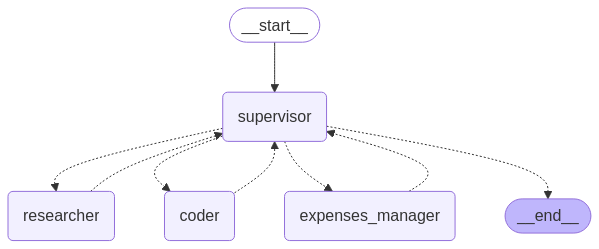

In [5]:
from IPython.display import display, Image

#display(Image(graph.get_graph().draw_mermaid_png()))

In [80]:
call_count = 0
call_count_max = 5
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
state: {'messages': [HumanMessage(content="What's the square root of 42?", additional_kwargs={}, response_metadata={}, id='b973e1c3-60aa-4a69-97f4-31af117474ca')], 'next': 'researcher'}
(('researcher:14d6fcfc-7d65-4e73-7525-7a3aa39e43d8',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-03-31T09:53:41.135202Z', 'done': True, 'done_reason': 'stop', 'total_duration': 511303700, 'load_duration': 58239300, 'prompt_eval_count': 205, 'prompt_eval_duration': 17000000, 'eval_count': 25, 'eval_duration': 430000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-407302f8-bc2a-4b97-8506-9bba4368824c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'square root of 42'}, 'id': '7e204dc2-b849-40ca-86f9-2985ce94e11b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 205, 'output_tokens': 25, 'total_to

In [7]:
call_count = 0
call_count_max = 5
events = graph.stream(
    {"messages": [("user", "Give me an insite on the spendings")]}, subgraphs=True
)


In [9]:
call_count = 0
call_count_max = 5
events = graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
)

In [79]:
my_array = []
for s in events:
    print(s)
    my_array.append(s)
    print("----")

In [12]:
my_array[0]


((), {'supervisor': {'next': 'researcher'}})

In [20]:
my_array[5][1]['supervisor']['next']


'expenses_manager'

In [ ]:
my_array[4][1]["expenses_manager"]["messages"][0].content  

'The square root of 42 is approximately 6.4807.'

In [37]:
my_array[4][1]["researcher"]["messages"][0].content

'The square root of 42 is approximately 6.4807.'

In [78]:
agents = []
j = -2
for i in range(len(my_array) - 1):
    try:
        if my_array[i][1]['supervisor']['next']:  # Check if 'next' key exists and is not empty
            j = j+1
           
            agent =  my_array[i][1]['supervisor']['next']
         
            agents.append(agent)

            #agent = agent.append(my_array[i][1]['supervisor']['next'])
            print(my_array[i - 1][1][agents[j]]["messages"][0].content)
            print("-----------")

            print("AGENT:", agent)
            
            
            
    except (KeyError, IndexError, TypeError):
        pass


The square root of 42 is approximately 6.4807.
-----------
AGENT: expenses_manager
That's a math question, but I'm an expenses manager, so I don't have access to real-time calculations or mathematical functions like calculating square roots. However, if you'd like, we can discuss your company's expenses and find ways to optimize them! 

If you'd like to know the expenses for any specific month, feel free to ask!
-----------
AGENT: coder
The square root of 42 is approximately 6.4807.

Let's discuss optimizing your company's expenses! Which month would you like to know the expenses for? I can help you analyze and find ways to reduce costs.
-----------
AGENT: researcher


In [65]:
agents[j]

'researcher'

In [58]:
agents = []
agents.append(23)

In [59]:
agents[0]

23

In [25]:
def get_valid_member_content(my_array, index, members):
    for member in members:
        try:
            content = my_array[index][1][member]["messages"][0].content
            return member, content  # Return the valid member and content
        except (KeyError, IndexError, AttributeError):
            continue  # Try the next member if the key is missing
    return None # Return None if no valid member is found

valid_member = get_valid_member_content(my_array, 4, members)


In [ ]:
for i in range(len(my_array) - 1):
    try:
        if my_array[i][1]['supervisor']['next']:  # Check if 'next' key exists and is not empty
            print("AGENT:", my_array[0][1]['supervisor']['next'])
            print(my_array[i + 1][1]["agent"]["messages"][0].content)
            print("-----------")
    except (KeyError, IndexError, TypeError):
        print("")